In [2]:
%load_ext autoreload
%autoreload 2
from tqdm import tqdm
from db_utils import init_and_connect
import pandas as pd

from settings import Settings

from dotenv import load_dotenv

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
load_dotenv()

settings = Settings()
db = init_and_connect(settings)

Connected to MongoDB


-- DB initialized -- 


In [30]:
db_bookings = list(
    db.course_bookings.find(
        {
            "available": True,
        }
    )
)

db_schedules = list(
    db.course_schedules.find(
        {
            "available": True,
        }
    )
)

db_rooms = list(
    db.rooms.find(
        {
            "available": True,
        }
    )
)

In [31]:
# populate course bookings objects with schedule objects
for booking in tqdm(db_bookings):
    schedule_id = booking["schedule_id"]

    for schedule in db_schedules:
        if schedule["_id"] == schedule_id:
            booking["schedule"] = schedule
            break

    room_id = booking["room_id"]

    for room in db_rooms:
        if room["_id"] == room_id:
            booking["room"] = room
            break

100%|██████████| 23374/23374 [00:41<00:00, 568.86it/s]


In [32]:
data = []
for booking in db_bookings:
    schedule = booking["schedule"]
    room = booking["room"]

    data.append(
        {
            "course_id": schedule["course_id"],
            "label": schedule["label"],
            "start_datetime": schedule["start_datetime"],
            "end_datetime": schedule["end_datetime"],
            "room_capacity": room["capacity"] if "capacity" in room else None,
            "room_name": room["name"],
        }
    )

In [33]:
rooms_with_capacity = []
for room in db_rooms:
    if "capacity" in room:
        rooms_with_capacity.append(room["name"])

print(f"Rooms with capacity: {len(rooms_with_capacity)}/{len(db_rooms)}")

Rooms with capacity: 172/181


In [34]:
for room in db_rooms:
    if room["name"] not in rooms_with_capacity:
        print(f"Room {room['name']} has no capacity")

Room ELD040 has no capacity
Room MED31122 has no capacity
Room CHB0427 has no capacity
Room CHB0374 has no capacity
Room CHB0375 has no capacity
Room PHC1425 has no capacity
Room BC129 has no capacity
Room BC229 has no capacity
Room BC329 has no capacity


In [35]:
df = pd.DataFrame(data)

In [36]:
db_courses = list(
    db.courses.find(
        {
            "available": True,
        }
    )
)

In [37]:
def get_course_name(course_id, db_courses):
    for course in db_courses:
        if course["_id"] == course_id:
            return course["name"]
    return None


def get_course_code(course_id, db_courses):
    for course in db_courses:
        if course["_id"] == course_id:
            return course["code"]
    return None

In [38]:
df["course_name"] = df["course_id"].apply(lambda x: get_course_name(x, db_courses))
df["course_code"] = df["course_id"].apply(lambda x: get_course_code(x, db_courses))

In [39]:
df.drop(columns=["course_id"], inplace=True)

In [252]:
df.to_csv("course_bookings.csv", index=False)

In [40]:
df["start_datetime"] = pd.to_datetime(df["start_datetime"])
df["end_datetime"] = pd.to_datetime(df["end_datetime"])

In [41]:
# find the total capacity per schedule per course (schedule can be multiple rooms at the same time)
total_capacity_per_schedule_per_course = df.groupby(
    ["course_code", "start_datetime", "end_datetime"]
).agg({"room_capacity": "sum"})

In [42]:
# find the max and min capacity per course
max_capacity_per_course = total_capacity_per_schedule_per_course.groupby(
    "course_code"
).agg({"room_capacity": "max"})
min_capacity_per_course = total_capacity_per_schedule_per_course.groupby(
    "course_code"
).agg({"room_capacity": "min"})

In [43]:
results = pd.merge(
    max_capacity_per_course,
    min_capacity_per_course,
    on="course_code",
    suffixes=("_max", "_min"),
).reset_index(drop=False)

In [44]:
courses_with_participants = pd.read_csv("courses_with_participants.csv")

In [45]:
# populate results with participants (or none if not found)
results["participants"] = results["course_code"].apply(
    lambda x: courses_with_participants[courses_with_participants["course_code"] == x][
        "participants"
    ].values[0]
    if x in courses_with_participants["course_code"].values
    else None
)

In [46]:
# compute the percentage of capacity used for min and max
results["percentage_capacity_used_min"] = (
    results["participants"] / results["room_capacity_min"]
)
results["percentage_capacity_used_max"] = (
    results["participants"] / results["room_capacity_max"]
)

In [47]:
results.to_csv("course_capacity.csv")

In [259]:
# Add day of the week
df["day_of_week"] = df["start_datetime"].dt.day_name()

In [ ]:
# filter for a standard week (feb 26th 2024 to march 3rd 2024)
week_df = df[
    (df["start_datetime"] >= "2024-02-26") & (df["start_datetime"] < "2024-03-03")
]


# Assuming start and end times are on the same day
def expand_hours(row):
    hours = (
        pd.date_range(start=row["start_datetime"], end=row["end_datetime"], freq="H")
        .to_series()
        .dt.hour.tolist()
    )
    return [(row["day_of_week"], h, row["room_capacity"]) for h in hours]


# Apply the function and explode the dataframe
hourly_capacity = week_df.apply(expand_hours, axis=1).explode().tolist()

# Convert the list to a dataframe
hourly_capacity_df = pd.DataFrame(hourly_capacity, columns=["Day", "Hour", "Capacity"])

# Group by day and hour, summing up the capacities
total_capacity_per_hour = (
    hourly_capacity_df.groupby(["Day", "Hour"]).sum().reset_index()
)

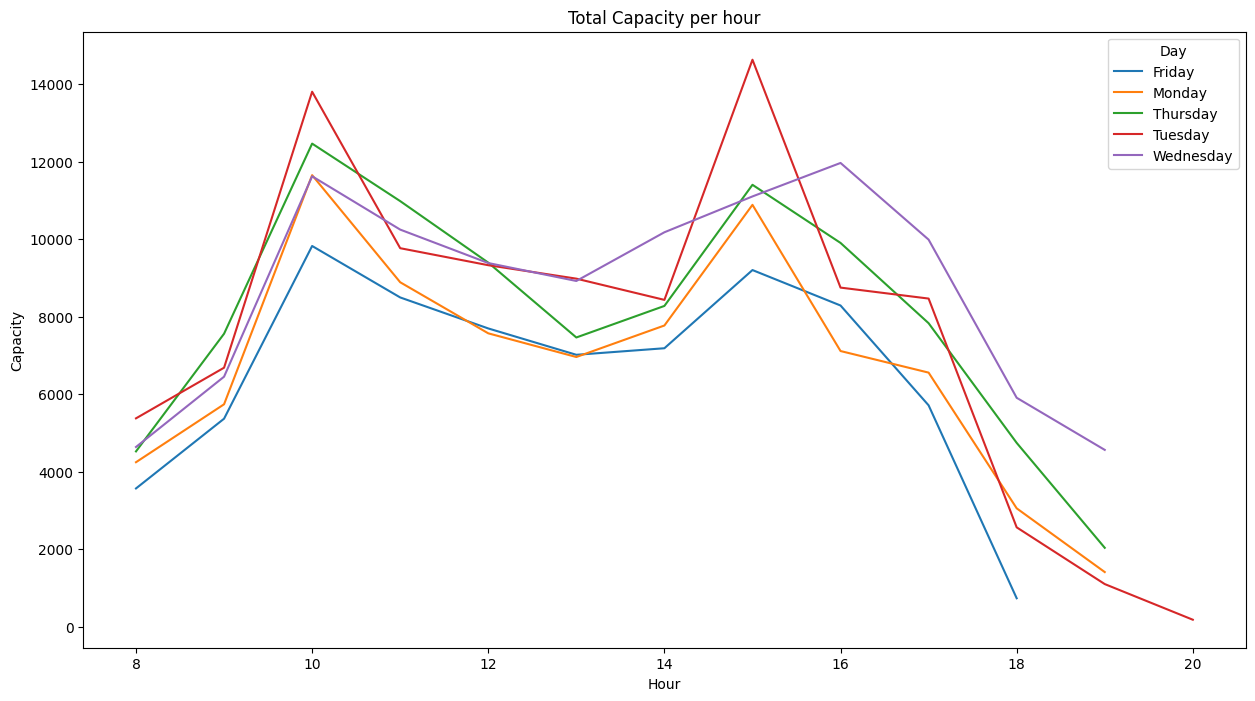

In [261]:
# plot the results
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(15, 8))
sns.lineplot(data=total_capacity_per_hour, x="Hour", y="Capacity", hue="Day")
plt.title("Total Capacity per hour")
plt.show()

In [22]:
old_courses_with_participants = pd.read_csv("courses_with_participants_old.csv")
courses_with_participants = pd.read_csv("moodle_courses_with_participants.csv")

In [4]:
old_courses_with_participants

,course_id,course_code,participants
0,18427,AR-123,208.0
1,7841,AR-101,270.0
2,10021,AR-102,201.0
3,15615,AR-113,223.0
4,16355,AR-114,259.0
...,...,...,...
1867,472,CS-442,206.0
1868,14114,CS-487,89.0
1869,6881,CS-489,NaN
1870,12821,CS-491,NaN


In [9]:
print(
    f"Old {old_courses_with_participants['participants'].isna().sum()}/{len(old_courses_with_participants)}"
)
print(
    f"New {courses_with_participants['participants'].isna().sum()}/{len(courses_with_participants)}"
)

Old 314/1872
New 240/1872


In [23]:
# fill nan values with the new dataset (if old is nan and new is not)
old_courses_with_participants["participants"] = old_courses_with_participants.apply(
    lambda row: courses_with_participants[
        courses_with_participants["course_code"] == row["course_code"]
    ]["participants"].values[0]
    if pd.isna(row["participants"])
    and not pd.isna(
        courses_with_participants[
            courses_with_participants["course_code"] == row["course_code"]
        ]["participants"].values[0]
    )
    else row["participants"],
    axis=1,
)

In [24]:
old_courses_with_participants["participants"].isna().sum()

98

In [26]:
old_courses_with_participants.to_csv("courses_with_participants.csv", index=False)

In [23]:
import requests


cookie = """_ga=GA1.1.327076087.1704497679; _ga_G365HJ4XFJ=GS1.1.1709644754.48.1.1709644761.0.0.0; MoodleSession=1v6be9920dln6k02gaioqa9q5j; MOODLEID1_=%25F5gr%2519%25D0c; AVIHTTPCOOKIE=0250707b82-8f91-41ACXfovbCN-KG0861HwSOazjhVRJM6MAUcke-MkpjLmEkqAnGz4NKPvxuXIoaw07_ifc; _ga_BH7LNYWR52=GS1.1.1709574496.7.0.1709574496.0.0.0; _ga_N6BF9H5G73=GS1.1.1709573674.59.0.1709573717.0.0.0; _ga_TM8N3HCMRH=GS1.2.1709573672.57.1.1709573674.0.0.0; _gid=GA1.2.1072110967.1709548615; _ga_WM9F2S83X0=GS1.1.1709562384.2.0.1709562386.0.0.0; _ga_MWT7D7P44V=GS1.1.1709562384.20.0.1709562384.0.0.0; _ga_E9R3EEVC8Q=GS1.2.1709553245.11.1.1709553249.0.0.0; _ga_8Z5GJB4ZJ5=GS1.1.1709296345.3.0.1709296345.0.0.0; _ga_TM8DEKLSZY=GS1.1.1709051122.4.1.1709051146.0.0.0; _ga_YJ6W6YYLQE=GS1.2.1708471203.2.0.1708471203.0.0.0; _ga_7G32YGJ4WS=GS1.1.1708443555.5.1.1708443619.0.0.0; _ga_2BGFE0Z1RT=GS1.1.1708363220.2.1.1708363401.60.0.2033304422; _ga_H0J1FCYCDJ=GS1.1.1708357054.1.0.1708357056.0.0.0; _ga_Z0TVSR8E94=GS1.1.1708263424.1.0.1708263432.0.0.0; _ga_GBVBTHC8QT=GS1.1.1707847074.2.1.1707848329.0.0.0; _ga_9G5MJW6PD9=GS1.1.1707842000.1.0.1707842007.0.0.0; _ga_NP2GD2L6ES=GS1.1.1707842000.1.0.1707842007.0.0.0; _ga_0954257HWG=GS1.1.1706617682.2.0.1706617682.0.0.0; _ga_REE6RQXRF5=GS1.1.1706617682.2.0.1706617682.0.0.0; _ga_T22HJJ0372=GS1.1.1706197612.4.1.1706198469.0.0.0; _ga_1XLT6CXS52=GS1.1.1705683492.1.1.1705683534.0.0.0; _ga_C0NGVJ6J1N=GS1.1.1705683478.1.1.1705683492.0.0.0; _ga_SH0469YBLK=GS1.1.1705674861.1.1.1705674918.0.0.0; _ga_ZWWCJVDX42=GS1.1.1705674861.1.1.1705674918.0.0.0; _ga_RFXRNEMNFJ=GS1.1.1705514594.1.0.1705514599.0.0.0; _ga_4HV8LPT5CM=GS1.2.1705504196.1.1.1705504225.0.0.0; petitpois=dismiss; logged_out_marketing_header_id=eyJfcmFpbHMiOnsibWVzc2FnZSI6IklqRTNOV0kzT0RJeExXRTBPRGt0TkRWaU9DMWhZbVZsTFRReVpqYzVOR0U1WTJGbVlTST0iLCJleHAiOm51bGwsInB1ciI6ImNvb2tpZS5sb2dnZWRfb3V0X21hcmtldGluZ19oZWFkZXJfaWQifX0%3D--d63977aa68e6321ed3223be2be2b29b4b3b07a0f"""
session_key = "Yy0p6OjLDE"


def request_course(courseid):
    url = f"https://moodle.epfl.ch/lib/ajax/service.php?sesskey={session_key}&info=core_table_get_dynamic_table_content"

    headers = {
        "Accept": "application/json, text/javascript, */*; q=0.01",
        "Accept-Encoding": "gzip, deflate, br",
        "Accept-Language": "en-GB,en;q=0.9",
        "Connection": "keep-alive",
        "Content-Type": "application/json",
        "Cookie": cookie,
        "Host": "moodle.epfl.ch",
        "Origin": "https://moodle.epfl.ch",
        "Referer": "https://moodle.epfl.ch/user/index.php?id=15769",
        "Sec-Fetch-Dest": "empty",
        "Sec-Fetch-Mode": "cors",
        "Sec-Fetch-Site": "same-origin",
        "User-Agent": "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/17.2.1 Safari/605.1.15",
        "X-Requested-With": "XMLHttpRequest",
    }

    r = requests.post(
        url,
        headers=headers,
        json=[
            {
                "index": 0,
                "methodname": "core_table_get_dynamic_table_content",
                "args": {
                    "component": "core_user",
                    "handler": "participants",
                    "uniqueid": "user-index-participants-15769",
                    "sortdata": [{"sortby": "lastname", "sortorder": 4}],
                    "jointype": 2,
                    "filters": {
                        "courseid": {
                            "name": "courseid",
                            "jointype": 1,
                            "values": [15769],
                        }
                    },
                    "firstinitial": "A",
                    "lastinitial": "",
                    "pagenumber": "1",
                    "pagesize": "20",
                    "hiddencolumns": [],
                    "resetpreferences": False,
                },
            }
        ],
    )

    return r

In [3]:
# extract all td elements from the response
from bs4 import BeautifulSoup


def extract_participants(r):
    soup = BeautifulSoup(r.text, "html.parser")
    return soup.find_all("tr")

In [24]:
r = request_course(15769)

In [26]:
# check if 'Agathe' is in the response
extract_participants(r)

[<tr><th c0\"="" class='\"header' scope='\"col\"'><input \n\="" all\"\n="" class='\"m-1\"' data-action='\"toggle\"\n' data-toggle='\"master\"\n' data-toggle-deselectall='\"Deselect' data-toggle-selectall='\"Select' data-togglegroup='\"participants-table\"\n' id='\"select-all-participants\"' name='\"select-all-participants\"' type='\"checkbox\"' value='\"\"\n'/>\n    <label class='\"sr-only\"' for='\"select-all-participants\"'>Select all&lt;\/label&gt;<div class='\"commands\"'>&lt;\/div&gt;&lt;\/th&gt;<th c1\"="" class='\"header' scope='\"col\"'><a data-sortable='\"1\"' data-sortby='\"firstname\"' data-sortorder='\"4\"' href='\"https:\/\/moodle.epfl.ch\/user\/index.php?id=15769&amp;tsort=firstname&amp;tdir=4\"' role='\"button\"'>First name<span \"="" class='\"accesshide'>Sort by First name Ascending&lt;\/span&gt;&lt;\/a&gt;  \/ <a data-sortable='\"1\"' data-sortby='\"lastname\"' data-sortorder='\"3\"' href='\"https:\/\/moodle.epfl.ch\/user\/index.php?id=15769&amp;tsort=lastname&amp;tdir